# Hot Air Balloon

Create a model predictive control application that adjusts flap and burner to rise to 1000 ft elevation and return to 0 ft elevation with a final downward velocity less than 0.1 m/s.

The elevation of a hot air ballooon is simulated with flap and burner adjustments. When the overall density of the balloon is less than air, the balloon rises. If the burner is turned off, the air inside the balloon cools and causes the balloon to become less dense. The flap can also be opened to descend because it lets the hot air escape, making the balloon air more dense. The position, velocity, and acceleration of the hot air balloon is simulated with a momentum balance.

* We focus on vertical movement of the balloon, which can be controlled by the fuel valve position f and vent valve position p.
* Vertical velocity v depends on lift, weight, and drag forces.
* Lift force is equal to the weight of the air displaced by the envelope (Archimedes’ principle).
* Drag force is proportional to the square of velocity.
* Air is an ideal gas, and atmospheric temperature falls off linearly with altitude.
* The envelope interior is isothermal at temperature $T_{i}$.
* Envelope volume V is constant, and pressure inside and outside the envelope is the same.
* The envelope interior temperature $T_{i}$ changes based on fuel valve position f, vent valve position p, and heat loss to the atmosphere.
The internal energy of the gas in the envelope dominates (over its kinetic and potential energy).
* Changes in the internal energy of the gas in the envelope due to pressure changes can be ignored.

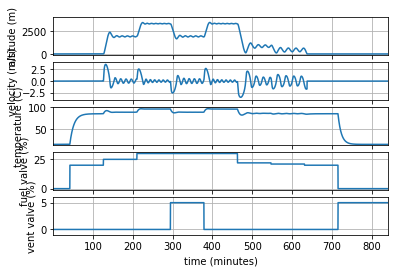

In [1]:
# This script simulates a Hot Air Balloon, type AX7-77, Head Balloons
# Tom Badgwell 06/07/17
import numpy as np
from scipy.integrate import odeint

def hab(x,t,alpha,gamma,mu,omega,delta,beta,u0,u1):
    # This function evaluates the ode right hand side
    #  for the hot air balloon simulation.

    # Calculate derivatives
    dxdt = np.zeros(3)
    Ths = 1 - delta*x[0]
    dxdt[0] = x[1]
    dxdt[1] = alpha*mu*(Ths**(gamma-1))*(1-(Ths/x[2])) \
              - mu -omega*x[1]*np.abs(x[1])
    dxdt[2] = -(x[2] - Ths)*(beta + u1) + u0
    return dxdt

# Set hot air balloon parameters
alpha = 5.098
gamma = 5.257
mu    = 0.1961
omega = 8.544
delta = 0.0255
beta  = 0.01683

# Set the variable scaling parameters

hr = 1000  # meters
tr = 10.10 # seconds
Tr = 288.2 # K
fr = 4870  # %
pr = 1485  # %

# Initialize simulation variables

t0       = 0
tf       = 5000
dt       = 0.25
N        = int(round((tf-t0)/dt) + 1)
# xstart   = [0.0 0.0 1.244] # neutral buoyancy
xstart   = [0.0,0.0,1.000] # ambient temperature
tstart   = 0
fk       = np.zeros(N)
pk       = np.zeros(N)
uk       = np.zeros((N,2))
xk       = np.zeros((N,3))
yk       = np.zeros((N,3))
tm       = np.zeros(N)
xk[0]    = xstart
C        = np.eye(3)
yk[0]    = np.dot(C,xstart)
tm[0]    = 0

# Initial conditions
fk = np.zeros(N)
pk = np.zeros(N)
fk[0:1000] =  0.0
pk[0:1000] =  0.0

# Warm up to nuetral buoyancy
fk[1000:3000] = 20.0
pk[1000:3000] =  0.0

# Takeoff
fk[3000:5000] = 25.0
pk[3000:5000] =  0.0

# Climb higher
fk[5000:7000] = 30.0
pk[5000:7000] =  0.0

# Open the vent
fk[7000:9000] = 30.0
pk[7000:9000] =  5.0

# Close the vent
fk[9000:11000] = 30.0
pk[9000:11000] =  0.0

# Descend
fk[11000:13000] = 22.0
pk[11000:13000] =  0.0

# Descend
fk[13000:15000] = 21.0
pk[13000:15000] =  0.0

# Land
fk[15000:17000] = 20.0
pk[15000:17000] =  0.0

# Close fuel valve and open the vent valve
fk[17000:N] =   0.0
pk[17000:N] =   5.0

# Make inputs dimensionless
uk[:,0] = fk/fr
uk[:,1] = pk/pr

# Run the simulation
for k in range(N):

    # Output iteration count
    #print('iteration ' + str(k))

    # Integrate the model for this time step
    parms = (alpha,gamma,mu,omega,delta,beta,uk[k,0],uk[k,1])
    tstop   = tstart + dt
    tspan   = [tstart, tstop]
    x   = odeint(hab, xstart, tspan, parms)

    # Impose constraints when on the ground
    if (x[-1,0] <= 0.0):
        x[-1,0] = 0.0
        x[-1,1] = 0.0

    # Store solution
    xk[k] = x[-1]
    yk[k] = np.dot(C,xk[k])
    tm[k]   = tr*tstop

    # Set initial state
    xstart = xk[k]
    tstart = tstop

# Recover dimensional outputs

hk  = yk[:,0]*hr
vk  = yk[:,1]*hr/tr
Tik = yk[:,2]*Tr - 273.2

# Convert time to minutes

tmm = tm/60

# Plot results
import matplotlib.pyplot as plt

plt.figure(1)

plt.subplot(5,1,1)
plt.plot(tmm,hk)
plt.xlim([1,tmm[-1]])
plt.ylim([-100,4000])
plt.grid()
plt.ylabel('altitude (m)')

plt.subplot(5,1,2)
plt.plot(tmm,vk)
plt.xlim([1,tmm[-1]])
plt.ylim([-4,4])
plt.grid()
plt.ylabel('velocity (m/s)')

plt.subplot(5,1,3)
plt.plot(tmm,Tik)
plt.xlim([1,tmm[-1]])
plt.ylim([14,100])
plt.grid()
plt.ylabel('temperature (C)')

plt.subplot(5,1,4)
plt.plot(tmm,fk)
plt.xlim([1,tmm[-1]])
plt.ylim([-1,31])
plt.grid()
plt.ylabel('fuel valve (%)')

plt.subplot(5,1,5)
plt.plot(tmm,pk)
plt.xlim([1,tmm[-1]])
plt.ylim([-1,6])
plt.grid()
plt.ylabel('vent valve (%)')
plt.xlabel('time (minutes)')

plt.show()